In [1]:
from core import download_IC
from core import download_ATNF

In [2]:
from core import readfiles
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import bisect

read icdata
read uptdata
read eadata
read mspdata


In [10]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# UNCOMMENT FOR LOGARITHMIC BINS
# all_enu = np.logspace(11.001, 18.999, 1000)

In [5]:
gamma_arr = [-1, -2.2, -2.5, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

#Uncomment to compute the background PDF for all neutrinos as per eqn 9 of 2205.15963

#and store them at /data/all_Bi.dat

#then recomment it


all_Bi = signals(4).compute_background()
all_Bi.tofile(os.getcwd() + '/data/all_Bi.dat', sep=',')

In [27]:
np.diff(all_enu)

array([5.84893192e+10, 9.26993239e+10, 1.46918527e+11, 2.32850174e+11,
       3.69042656e+11, 5.84893192e+11, 9.26993239e+11, 1.46918527e+12,
       2.32850174e+12, 3.69042656e+12, 5.84893192e+12, 9.26993239e+12,
       1.46918527e+13, 2.32850174e+13, 3.69042656e+13, 5.84893192e+13,
       9.26993239e+13, 1.46918527e+14, 2.32850174e+14, 3.69042656e+14,
       5.84893192e+14, 9.26993239e+14, 1.46918527e+15, 2.32850174e+15,
       3.69042656e+15, 5.84893192e+15, 9.26993239e+15, 1.46918527e+16,
       2.32850174e+16, 3.69042656e+16, 5.84893192e+16, 9.26993239e+16,
       1.46918527e+17, 2.32850174e+17, 3.69042656e+17, 5.84893192e+17,
       9.26993239e+17, 1.46918527e+18, 2.32850174e+18, 3.69042656e+18])

In [6]:
#
all_Bi = np.loadtxt(os.getcwd() + '/data/all_Bi.dat', delimiter=',')

In [7]:
weight_obj =  [weights.weights(gamma).all_weights for gamma in gamma_arr]
sum_weights = [weights.weights(gamma).sum_weights for gamma in gamma_arr]

In [8]:
#Calculating weight/sum(weights) to avoid wrong ns = 0 entries 
normalized_wt = []
for gamma in range(4):
    temp = []
    for season in range(len(weight_obj[gamma])):
        temp.append(weight_obj[gamma][ea_season(season)]/sum_weights[gamma][ea_season(season)])
    normalized_wt.append(temp)

In [9]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963
all_Si = np.asfarray([signals(gamma_arr[i]).compute_signal() for i in tqdm(prange(4))])

100%|██████████| 4/4 [01:34<00:00, 23.66s/it]


In [12]:
#generates ns^ for a single pulsar a single season and a single energy

@njit(fastmath=True)
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0 = 1, season=0):
    '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


    tt_upt = t_upt[season]
    if enu <= 1e11 or enu >= 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu_wall)):
            if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
                for j in range(0, len(dec_nu)):
                    if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                        k=i
                        l=j
                        break
                break

        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * temp_ea * dfde(enu, gamma, phi0)     #in s cm2 eV


In [13]:
#For each gamma, find ns and find TS(ns*phi0)
#FIND TS as in eqn 3 of 2205.15963 WIHTOUT w_acc

#28032023 SD suggestion - USE trapz

all_TSS = []
all_TSS_with_wt = []
nss_all_gamma = []
for gamma in prange(4):
    nss_all_eng = []
    psrns = 0
    for psrdec in range(p):
        for season in prange(10):
            tmp = [ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[i], gamma_arr[gamma], 1 ,season=season) for i in range(len(all_enu))]
            # psrns += np.trapz(y=tmp, x=all_enu)
            psrns += np.trapz(y=tmp, dx=np.diff(all_enu))
    nss_all_eng.append(psrns)
    
    @njit
    def TS_for_all_psrs2(nsa):  
        return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)      #No units

    pool = mul.Pool(12, maxtasksperchild=200)
    op_arr = pool.map_async(TS_for_all_psrs2, nss_all_eng*phio) #No units
    temp = op_arr.get()
    pool = []
    op_arr = []
    all_TSS.append(temp)

    nss_all_gamma.append(nss_all_eng)

In [ ]:
ns_singleseason_sing_psr_HAT()

In [38]:
phi0t = 1e-30
season = 0
dec = msdec[0]
print("Decl = ", dec)
tmp = [ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[i], gamma_arr[gamma], phi0t ,season=season) for i in range(len(all_enu))]
print(np.trapz(y=tmp, dx=np.diff(all_enu)))
print(np.trapz(y=tmp, dx = 1e9* (10**0.2)))

Decl =  62.26928
0.1311373925117263
0.0003249283944427698


In [14]:
nss_all_gamma #without weights

[[1.2862713324684008e+34],
 [4.90689698875283e+32],
 [9.84932063295231e+32],
 [6.190342154843736e+33]]

### $N \approx 10^6$

In [47]:
earea.shape

(5, 2000)

In [31]:
#For each gamma, find ns and find TS(ns*phi0)
#FIND TS as in eqn 3 of 2205.15963 INCLUDING w_acc

#28032023 SD suggestion - USE trapz


# all_TSS = []
all_TSS_with_wt = []
nss_all_gamma = []
for gamma in prange(4):
    nss_all_eng = []
    psrns = 0
    for psrdec in range(p):
        for season in prange(10):    
            # for enu in range(len(all_enu)):
            tmp = [ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[i], gamma_arr[gamma], 1 ,season=season) for i in range(len(all_enu))]
            # wt = normalized_wt[gamma][ea_season(season)][psrdec]
            # tmp = [wt * ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[i], gamma_arr[gamma], 1 ,season=season) for i in range(len(all_enu))]
            psrns += np.trapz(y=tmp, dx=1e9 * (10**0.2))
    nss_all_eng.append(psrns)
    
    @njit
    def TS_for_all_psrs2(nsa):  
        return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)      #No units

    pool = mul.Pool(12, maxtasksperchild=200)
    op_arr = pool.map_async(TS_for_all_psrs2, nss_all_eng*phio) #No units
    temp = op_arr.get()
    pool = []
    op_arr = []
    all_TSS_with_wt.append(temp)

    nss_all_gamma.append(nss_all_eng)

In [33]:
nss_all_gamma

[[1.310325925182532e+28],
 [5.058502949128222e+29],
 [2.2035232073353446e+30],
 [3.2137009485554804e+31]]

In [34]:
for i in range(4):
    print(min(all_TSS[i]), max(all_TSS[i]))

-5770046.567530383 -6.700279992073946e-07
-10056438.664036427 0.31081377984207614
-6227487.13316004 0.3972334946681238
-7580392.187670537 0.41843329021536596


In [35]:
for i in range(4):
    print(min(all_TSS_with_wt[i]), max(all_TSS_with_wt[i]))

-1.3277046089384044 5.4299231777575546e-11
-646.5250609881108 0.3108262106460978
-8624.167427169534 0.3971784434588998
-451433.7944650374 0.4184551744918847


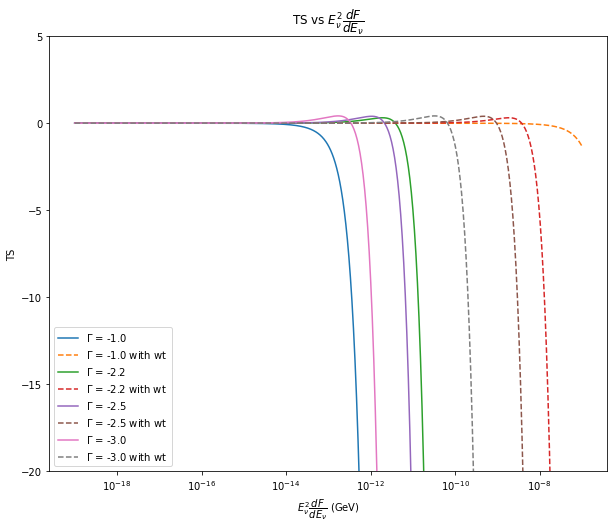

In [36]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)
e2dfde = []

for i in prange(4):
    temp = []
    for phi in range(len(phio)):
        temp.append( 1e28 * dfde(1e14, gamma_arr[i], phio[phi]))        #in eV
    e2dfde.append(temp)

e2dfde = np.asarray(e2dfde)
mark = ['^', 'o', 's', 'd']
plt.figure(figsize=(10,8))
for i in [0, 1, 2, 3]:#range(4):
    plt.plot(e2dfde[i]/1e9, all_TSS[i], label='$\Gamma$ = ' + str(gamma_arr[i]))    #in GeV
    plt.plot(e2dfde[i]/1e9, all_TSS_with_wt[i], ls='--',label='$\Gamma$ = ' + str(gamma_arr[i]) + ' with wt')    #in GeV

plt.legend()
plt.xscale('log')
plt.xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
plt.ylabel('TS')
plt.title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
# plt.xlim(1e-30, 1e-22)
plt.ylim(-20, 5)
plt.show()

x1 = np.logspace(1, 10, 1000)

y1 = lambda f, xx: np.trapz(y=f(xx), x= xx)
y2 = lambda f1, xx1: np.trapz(y=f1(xx1), dx= np.diff(xx1))

np.log10(y1(np.square, x1))

np.log10(y2(np.square, xx1=x1))

x1 = np.linspace(1e1, 1e10, 1000)

np.log10(y1(np.square, x1))

np.log10(y2(np.square, x1))

aa =np.linspace(1e1, 1e10, num=1000)
np.trapz(aa**2, dx = np.diff(aa))

np.trapz(aa**2, x=aa)

aa =np.logspace(1, 10, num=1000)
np.trapz(aa**2, dx = np.diff(aa))

np.trapz(aa**2, x=aa)

import scipy.integrate as scint

scint.quad(np.square, 1e1, 1e10)